# Generacion de datos sinteticos

**Problema**: Este conjunto de datos simula transacciones bancarias en una institución financiera, con el objetivo de detectar fraudes.

- Transacciones recientes (imagine_transacciones.csv): Representan operaciones registradas en el sistema, incluyendo detalles como el monto, el tipo de transacción, la ubicación y la hora en que ocurrió. Algunas transacciones han sido marcadas como fraudulentas (Fraudulenta = 1).
- Historial de transacciones previas (imagine_clientes_info.json): Contiene información sobre compras anteriores de cada cliente. Estas transacciones fueron realizadas en el pasado (con TransactionID más bajos) e incluyen una indicación de si fueron fraudulentas o no.

In [1]:
import pandas as pd
import numpy as np
import json

# Fijar semilla para reproducibilidad
np.random.seed(1142)

# Generar datos estructurados (CSV)
n_customers = 500
customer_ids = np.repeat(np.arange(1, n_customers + 1), np.random.randint(1, 6, n_customers))
transaction_ids = np.arange(10000, 10000 + len(customer_ids))
monto = np.round(np.random.uniform(10, 5000, len(customer_ids)), 2)
tipos_transaccion = np.random.choice(["Compra", "Retiro", "Transferencia", "Pago"], len(customer_ids))
ubicaciones = np.random.choice(["EE.UU.", "México", "España", "Colombia", "Argentina"], len(customer_ids))
horas = [f"{h:02}:{m:02}" for h, m in zip(np.random.randint(0, 24, len(customer_ids)), np.random.randint(0, 60, len(customer_ids)))]  # Generar horas en formato HH:MM

# Generar la variable objetivo (1 = fraude, 0 = legítima)
fraudulenta = np.random.choice([0, 1], len(customer_ids), p=[0.9, 0.1])  # 10% de fraudes

df = pd.DataFrame({
    "TransactionID": transaction_ids,
    "CustomerID": customer_ids,
    "Monto": monto,
    "TipoTransaccion": tipos_transaccion,
    "Ubicación": ubicaciones,
    "Hora": horas,
    "Fraudulenta": fraudulenta
})

# Introducir valores nulos aleatorios
def introduce_nulos(df, column, fraction=0.05):
    n = int(len(df) * fraction)
    idx = np.random.choice(df.index, n, replace=False)
    df.loc[idx, column] = np.nan

introduce_nulos(df, "Monto", 0.02)
introduce_nulos(df, "TipoTransaccion", 0.01)

# Introducir duplicados aleatorios
duplicates = df.sample(frac=0.015, random_state=42)
df = pd.concat([df, duplicates], ignore_index=True)

df.to_csv("imagine_transacciones.csv", index=False)

# Generar datos semi-estructurados (JSON)
clientes_info = {}
for cid in range(1, n_customers + 1):
    num_transacciones = np.random.randint(1, 6)  # Entre 1 y 5 transacciones previas
    transacciones_previas = [
        {
            "TransactionID": np.random.randint(2000, 7000),  # TransactionIDs bajos simulando transacciones antiguas
            "Fraudulenta": int(np.random.choice([0, 1], p=[0.85, 0.15]))  # 15% de fraude en transacciones previas
        }
        for i in range(num_transacciones)
    ]
    clientes_info[cid] = {"TransaccionesPrevias": transacciones_previas}

# Guardar JSON
with open("imagine_clientes_info.json", "w") as f:
    json.dump(clientes_info, f, indent=4)

/home/daniels/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/daniels/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Manipulación y Procesamiento de Datos

In [2]:
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Cargar datos
df = pd.read_csv("imagine_transacciones.csv")

with open("imagine_clientes_info.json", "r") as f:
    clientes_info = json.load(f)

## Limpieza de datos

In [3]:
print("Datos nulos:")
print(df.isnull().sum())
print("Duplicados:", df.duplicated().sum())

Datos nulos:
TransactionID       0
CustomerID          0
Monto              29
TipoTransaccion    14
Ubicación           0
Hora                0
Fraudulenta         0
dtype: int64
Duplicados: 22


In [4]:
# Manejo de valores nulos
# Opción 1: Eliminar filas con valores nulos
#df = df.dropna()

# Opción 2: Rellenar valores nulos con la media en columnas numéricas
df.fillna(df.mean(numeric_only=True), inplace=True)

# Opción 3: Rellenar valores nulos con un valor específico en columnas categóricas
df.fillna({"TipoTransaccion": "Desconocido", "Ubicación": "No especificado"}, inplace=True)

# Eliminar duplicados
df = df.drop_duplicates()

In [5]:
print("Datos nulos:")
print(df.isnull().sum())
print("Duplicados:", df.duplicated().sum())

Datos nulos:
TransactionID      0
CustomerID         0
Monto              0
TipoTransaccion    0
Ubicación          0
Hora               0
Fraudulenta        0
dtype: int64
Duplicados: 0


## Analisis exploratorio

In [6]:
profile = ProfileReport(df, title="Reporte de Análisis de Datos")
display(profile)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 19.70it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Transformación de datos

In [7]:
# Crear variable a partir de datos no estructurados HistorialFraudes
historial_fraudes = []
for customer_id, info in clientes_info.items():
    transacciones_previas = info["TransaccionesPrevias"]
    num_fraudes = sum(t["Fraudulenta"] for t in transacciones_previas)
    historial_fraudes.append({"CustomerID": int(customer_id), "HistorialFraudes": num_fraudes})

df_fraudes = pd.DataFrame(historial_fraudes)

# Unir dataframes por CustomerID
df = df.merge(df_fraudes, on="CustomerID", how="left")

# Convertir 'Hora' de formato HH:MM a un número entero de hora
df["HoraNumerica"] = df["Hora"].str.split(":").str[0].astype(int)

# Crear variable de hora por rangos
bins = [0, 6, 12, 18, 24]
labels = ["Madrugada", "Mañana", "Tarde", "Noche"]
df["MomentoDia"] = pd.cut(df["HoraNumerica"], bins=bins, labels=labels, right=False)

# Guardar datos procesados
df.to_csv("imagine_transacciones_limpiadas.csv", index=False)

# Implementación de un Modelo de Machine Learning

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="pandas.core.computation.expressions")

# Cargar los datos limpios
df = pd.read_csv("imagine_transacciones_limpiadas.csv")

## Preprocesamiento

In [9]:
# Definir variables categóricas y su tratamiento
categorical_ordinal = ["MomentoDia"]
categorical_nominal = ["TipoTransaccion", "Ubicación"]
numerical_features = ["Monto", "HistorialFraudes"]

# Codificación de variables categóricas
ordinal_encoder = OrdinalEncoder(categories=[["Madrugada", "Mañana", "Tarde", "Noche"]])
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# Definir variable objetivo
X = df.drop(columns=["Fraudulenta", "TransactionID", "CustomerID", "Hora", "HoraNumerica"])
y = df["Fraudulenta"]

# Ajustar pesos al tratarse de un objetivo desvalanceado
class_weights = compute_class_weight("balanced", classes=np.unique(y), y=y)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Selección y entrenamiento del modelo
Se entrenana 2 modelos Regresión Logística y Gradient Boosting

In [10]:
# Modelos
models = {
    "Regresión Logística": Pipeline([
        ("preprocessor", ColumnTransformer([
            ("ordinal", Pipeline([
                ("encoder", ordinal_encoder),
                ("scaler", StandardScaler())  # Codificacion y normalizacion de variables categoricas ordinales
            ]), categorical_ordinal),
            ("onehot", one_hot_encoder, categorical_nominal), # Codificacion de variables categoricas nominales
            ("scaler", StandardScaler(), numerical_features)  # Normalización de variables numericas
        ])),
        ("classifier", LogisticRegression(class_weight=class_weight_dict))
    ]),
    "Gradient Boosting": Pipeline([
        ("preprocessor", ColumnTransformer([
            ("ordinal", ordinal_encoder, categorical_ordinal),
            ("onehot", one_hot_encoder, categorical_nominal)  # Sin normalización debido a la naturaleza del modelo
        ])),
        ("classifier", GradientBoostingClassifier())
    ])
}

# Hiperparámetros para GridSearch
param_grid = {
    "Regresión Logística": {"classifier__C": [0.01, 0.1, 1, 10, 100]},
    "Gradient Boosting": {
        "classifier__n_estimators": [50, 100, 200, 300],
        "classifier__learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2],
        "classifier__max_depth": [3, 5, 7]
    }
}

## Evaluación del modelo

Entrenando Regresión Logística...
Mejores parámetros para Regresión Logística: {'classifier__C': 10}
Resultados de Regresión Logística:
              precision    recall  f1-score   support

           0       0.90      0.55      0.68       264
           1       0.11      0.48      0.18        31

    accuracy                           0.54       295
   macro avg       0.51      0.51      0.43       295
weighted avg       0.82      0.54      0.63       295

Entrenando Gradient Boosting...
Mejores parámetros para Gradient Boosting: {'classifier__learning_rate': 0.001, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}
Resultados de Gradient Boosting:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       264
           1       0.00      0.00      0.00        31

    accuracy                           0.89       295
   macro avg       0.45      0.50      0.47       295
weighted avg       0.80      0.89      0.85       295



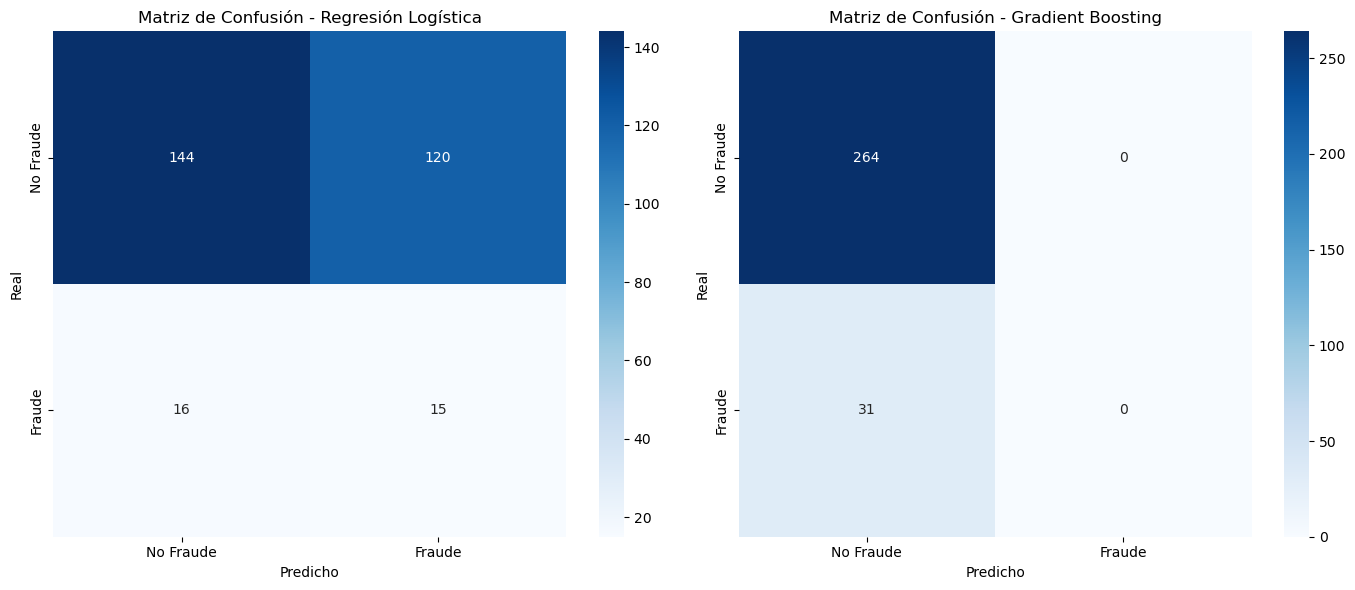

In [14]:
# Evaluación y comparación de modelos

metrics_comparison = {}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i, (model_name, model) in enumerate(models.items()):
    print(f"Entrenando {model_name}...")
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"Mejores parámetros para {model_name}: {grid_search.best_params_}")
    y_pred = grid_search.best_estimator_.predict(X_test)
    y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
    
    # Reporte de métricas
    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    metrics_comparison[model_name] = {
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-score": report["weighted avg"]["f1-score"]
    }
    print(f"Resultados de {model_name}:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraude", "Fraude"], yticklabels=["No Fraude", "Fraude"], ax=axes[i])
    axes[i].set_xlabel("Predicho")
    axes[i].set_ylabel("Real")
    axes[i].set_title(f"Matriz de Confusión - {model_name}")

plt.tight_layout()
plt.show()

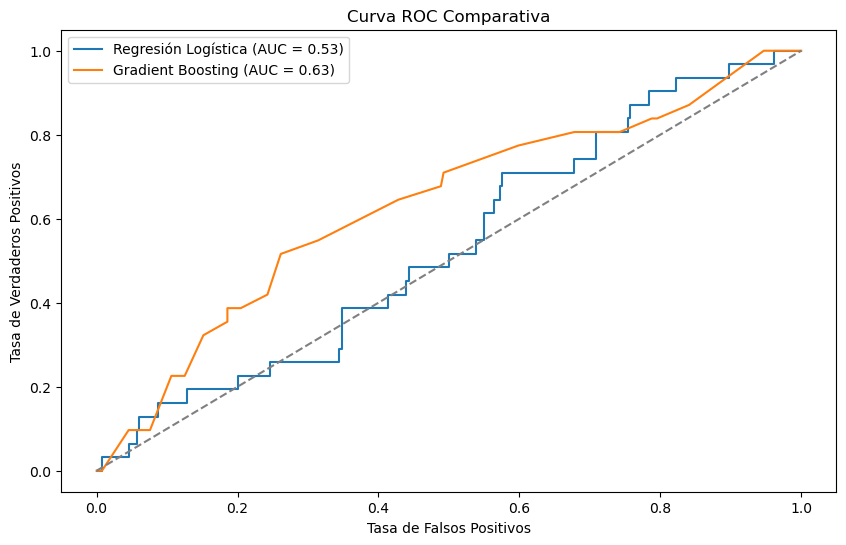

In [15]:
# Curva ROC Comparativa
plt.figure(figsize=(10, 6))
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC Comparativa")
plt.legend()
plt.show()

In [16]:
# Comparación de métricas
df_metrics = pd.DataFrame(metrics_comparison).T
print("\nComparación de métricas entre modelos:")
display(df_metrics)


Comparación de métricas entre modelos:


,Precision,Recall,F1-score
Regresión Logística,0.817100,0.538983,0.626858
Gradient Boosting,0.800873,0.894915,0.845287


In [17]:
import joblib

if "Regresión Logística" in metrics_comparison:
    best_logistic_model = grid_search.best_estimator_
    joblib.dump(best_logistic_model, "mejor_modelo_logistic_regression.pkl")
    print("Mejor modelo de Regresión Logística guardado como 'mejor_modelo_logistic_regression.pkl'")

Mejor modelo de Regresión Logística guardado como 'mejor_modelo_logistic_regression.pkl'
